# Linear Quadratic Regulator

参考：
* [Reinforcement Learning: Theory and Algorithms](https://rltheorybook.github.io/)

LQRは最適制御の手法の一つです．一般には次のようなダイナミクスを対象とします．

$$x_{t+1}=f_t\left(x_t, u_t, w_t\right)$$

ここで$x$は状態，$u$は制御入力，$w$は摂動です．また，最適制御は次のような最適化を考えます．

$$
\begin{array}{ll}
\operatorname{minimize} & \mathbb{E}_\pi\left[\sum_{t=0}^H c_t\left(x_t, u_t\right)\right] \\
\text { such that } & x_{t+1}=f_t\left(x_t, u_t, w_t\right) t=0, \ldots, H
\end{array}
$$

LQRは特に次のような線形なダイナミクスを制御することを考えます．

$$
x_{t+1}=A_t x_t+B_t u_t+w_t
$$

ここで，$A_t$と$B_t$はダイナミクス$f$の勾配です．また，コスト関数は$x_t$と$u_t$によって近似されるとします．

## 有限ホライゾンのLQR

有限ホライゾンは以下の最適化問題を扱います．

$$
\operatorname{minimize} \quad \mathbb{E}\left[x_H^{\top} Q x_H+\sum_{t=0}^{H-1}\left(x_t^{\top} Q x_t+u_t^{\top} R u_t\right)\right]
$$
such that $\quad x_{t+1}=A_t x_t+B_t u_t+w_t, \quad x_0 \sim \mathcal{D}, w_t \sim N\left(0, \sigma^2 I\right)$

ここで，

* 初期状態：$x_0 \sim \mathcal{D}$
* ノイズ：$w_t\in \mathbb{R}^d$．共分散は$\sigma^2 I$に従うとします．
* 遷移行列：$A_t \in \mathbb{R}^{d\times d}$， $B_t \in \mathbb{R}^{d\times k}$
* $Q_t \in \mathbb{R}^{d\times d}$，$R_t \in \mathbb{R}^{k\times k}$は正定値行列です．

これは$\mathcal{S}= \mathbb{R}^d$かつ$\mathcal{A}=\mathbb{R}^d$の有限ホライゾンMDPであることに注意しましょう．


### 有限ホライゾンLQRの解き方

LQRで扱うダイナミクスもMDPの一種であるため，ベルマン方程式のようなものが成立します．
次のような価値関数を考えましょう．

$$
V_h^\pi(x)=\mathbb{E}\left[x_H^{\top} Q x_H+\sum_{t=h}^{H-1}\left(x_t^{\top} Q x_t+u_t^{\top} R u_t\right) \mid \pi, x_h=x\right]
$$

同様にして，行動価値関数も定義します．

$$
Q_h^\pi(x, u)=\mathbb{E}\left[x_H^{\top} Q x_H+\sum_{t=h}^{H-1}\left(x_t^{\top} Q x_t+u_t^{\top} R u_t\right) \mid \pi, x_h=x, u_h=u\right]
$$


このとき，次が成立します．

---

**LQR制御器**

$R$は正定値行列であるとする．このとき，最適な方策（制御器）は次で与えられる：

$$
\begin{aligned}
&\pi^{\star}\left(x_t\right)=-K_t^{\star} x_t\\
&\text{where }\; K_t^{\star}=\left(B_t^{\top} P_{t+1} B_t+R\right)^{-1} B_t^{\top} P_{t+1} A_t
\end{aligned}
$$

この$K$のことを**ゲイン**という．
ここで，$P_t$は次のように再帰的に計算される（$P_t$は正定値行列であることに注意しよう．つまり対称でもある．）．この方程式をリッカチ方程式と呼ぶ．

$$
\begin{aligned}
P_t & :=A_t^{\top} P_{t+1} A_t+Q-A_t^{\top} P_{t+1} B_t\left(B_t^{\top} P_{t+1} B_t+R\right)^{-1} B_t^{\top} P_{t+1} A_t \\
& =A_t^{\top} P_{t+1} A_t+Q-\left(K_{t+1}^{\star}\right)^{\top}\left(B_t^{\top} P_{t+1} B_t+R\right) K_{t+1}^{\star}
\end{aligned}
$$

また，$P_H=Q$とする．
このとき，最適な状態価値は

$$
V_t^{\star}(x)=x^{\top} P_t x+\sigma^2 \sum_{h=t+1}^H \operatorname{Trace}\left(P_h\right)
$$

で与えられる．

---

証明は省略します（MDPのベルマン方程式を解くのとだいたい同じなので）．
実装してみましょう．

In [29]:
# 倒立紳士のモデルを使います：https://jp.mathworks.com/help/control/ref/lti.lqr.html
import jax.numpy as jnp
import jax
from typing import NamedTuple


# 有限ホライゾン用です
class MDP(NamedTuple):
    d: int  # 状態の次元
    k: int  # 入力の次元
    H: int  # ホライゾン
    A: jnp.array  # 遷移行列
    B: jnp.array  # 遷移行列
    Q: jnp.array  # コスト行列
    R: jnp.array  # コスト行列
    sigma: float  # ノイズの大きさ


d = 4
k = 1
H = 30
sigma = 0.1
A = jnp.array([
    [0, 1, 0, 0],
    [0, -0.1, 3, 0],
    [0, 0, 0, 1],
    [0, -0.5, 30, 0],
]) * 0.1
A = jnp.repeat(A[None, :, :], H, axis=0)
B = jnp.array([[0,], [2,], [0,], [5,]])
B = jnp.repeat(B[None, :, :], H, axis=0)
Q = jnp.array([
    [1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 0],
])
R = jnp.eye(1)

mdp = MDP(d, k, H, A, B, Q, R, sigma)

In [30]:
import chex


@jax.jit
def compute_P_and_gain(mdp: MDP):
    """MDPについて，リッカチ方程式を複数回走らせてPを計算します．
    また，その結果を利用してゲインも計算します．

    Args:
        mdp (MDP)

    Returns:
        P (jnp.ndarray): (Hxdxd)の行列
        gain (jnp.ndarray): (Hxdxd)の行列
    """
    H, d, _ = mdp.A.shape
    Q, R = mdp.Q, mdp.R

    def backup(i, args):
        P, K = args
        h = H - i - 1

        # まずPを計算します
        P_h1 = P[h+1]
        A_h, B_h = mdp.A[h], mdp.B[h]
        P_h = A_h.T @ P_h1 @ A_h 
        P_h = P_h + Q
        P_h = P_h - A_h.T @ P_h1 @ B_h @ jnp.linalg.inv(B_h.T @ P_h1 @ B_h + R) @ B_h.T @ P_h1 @ A_h
        P = P.at[h].set(P_h)

        # 続いてゲインを計算します
        K_h = jnp.linalg.inv(B_h.T @ P_h1 @ B_h + R) @ B_h.T @ P_h1 @ A_h
        K = K.at[h].set(K_h)
        return P, K
    
    P = jnp.zeros((H+1, d, d))
    K = jnp.zeros((H, k, d))
    P = P.at[H].set(mdp.Q)
    args = P, K
    P, K = jax.lax.fori_loop(0, mdp.H, backup, args)
    return P[:-1], K


In [31]:
import matplotlib.pyplot as plt

# 制御器をダイナミクス上で走らせて得られる価値を観察します
P, gain = compute_P_and_gain(mdp)
Ptrace = jax.vmap(jnp.trace)(P)  # 解析的な最適価値の計算に使います

key = jax.random.PRNGKey(0)
x0 = jax.random.normal(key, (d,))

Vs = []
Vstars = []
inputs = []
outputs = []
for seed in range(10):
    x = x0.copy()
    V = []
    Vstar = []
    xs = []
    us = []
    for h in range(H):
        u = - gain[h] @ x

        xs.append(x[0])
        us.append(u)

        # 理論に基づいて最適な状態価値を計算します
        coststar = x.T @ P[h] @ x + mdp.sigma ** 2 * Ptrace[h+1:-1].sum()
        Vstar.append(coststar)

        # コストを計算します
        cost = x.T @ mdp.Q @ x + u.T @ mdp.R @ u
        V.append(cost)

        # ダイナミクスを進めます
        key, newkey = jax.random.split(key, 2)
        noise = jax.random.normal(newkey, (1,)) * mdp.sigma
        x = mdp.A[h] @ x + mdp.B[h] @ u + noise

    cost = x.T @ mdp.Q @ x
    V.append(cost)

    V = jnp.array(V[::-1])
    V = jnp.cumsum(V)[::-1]
    Vs.append(V)
    Vstars.append(Vstar)
    inputs.append(us)
    outputs.append(xs)

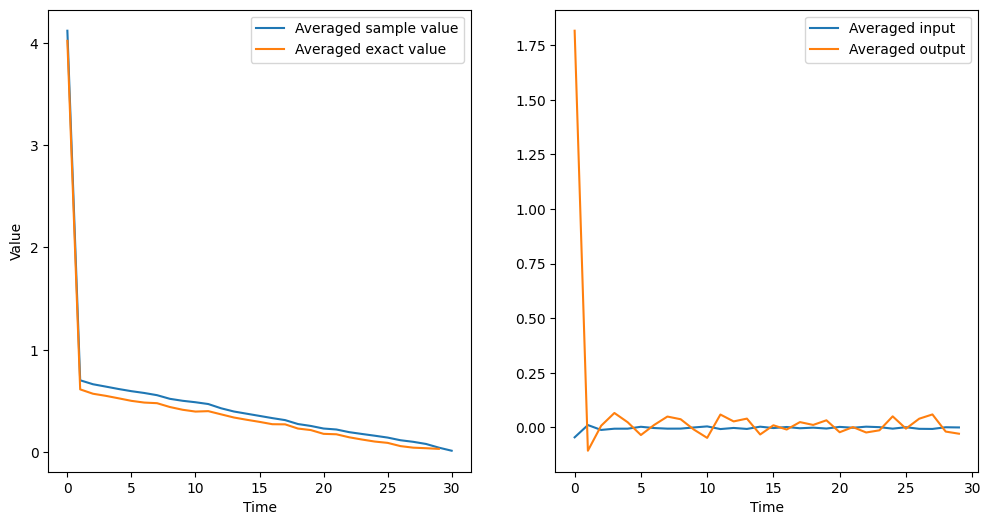

In [32]:
mean_V = jnp.array(Vs).mean(axis=0)
mean_Vstar = jnp.array(Vstars).mean(axis=0)
mean_input = jnp.array(inputs).mean(axis=0)
mean_output = jnp.array(outputs).mean(axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mean_V, label=f"Averaged sample value")
plt.plot(mean_Vstar, label=f"Averaged exact value")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_input, label=f"Averaged input")
plt.plot(mean_output, label=f"Averaged output")
plt.xlabel("Time")
plt.legend()

## 無限ホライゾンのLQR

無限ホライゾンでは以下の最適化問題を扱います．

$$
\begin{array}{ll}
\operatorname{minimize} & \lim _{H \rightarrow \infty} \frac{1}{H} \mathbb{E}\left[\sum_{t=0}^H\left(x_t^{\top} Q x_t+u_t^{\top} R u_t\right)\right] \\
\text { such that } & x_{t+1}=A x_t+B u_t+w_t, \quad x_0 \sim \mathcal{D}, w_t \sim N\left(0, \sigma^2 I\right) .
\end{array}
$$

$$
\operatorname{minimize} \quad \mathbb{E}\left[x_H^{\top} Q x_H+\sum_{t=0}^{H-1}\left(x_t^{\top} Q x_t+u_t^{\top} R u_t\right)\right]
$$
such that $\quad x_{t+1}=A_t x_t+B_t u_t+w_t, \quad x_0 \sim \mathcal{D}, w_t \sim N\left(0, \sigma^2 I\right)$


---

**可制御**について

最適な目的関数は有限であるとします．このような条件を**可制御**である，といいます．
以下では$A$と$B$が可制御の仮定を満たすとします．

---

---

**割引率は必要？**

LQRでは一般に割引率は考えません．
無限ホライゾンにおいて目的関数が無限になってしまった場合に割引率を導入したとしても，可制御になるとは限らないためです．

---

### 無限ホライゾンLQRの解き方

無限ホライゾンも有限ホライゾンと同様に，リッカチ方程式を使うことで解くことができます．
次のリッカチ方程式の解を$P$とします．

$$
P=A^T P A+Q-A^T P B\left(B^T P B+R\right)^{-1} B^T P A .
$$

このとき，最適方策は

$$
\begin{gathered}
\pi^{\star}(x)=-K^{\star} x \\
\text{where }\; K^*=-\left(B^T P B+R\right)^{-1} B^T P A .
\end{gathered}
$$

で与えられ，最適価値は

$$
\sigma^2 \operatorname{Trace}(P)
$$

になります．
